# PlotResults.ipynb
### example notebook demonstrating how to plot and inspect simulation outputs

In [1]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import copy
plt.style.use('seaborn-notebook')

In [2]:
from MADLens.util import *

### list all possible run files

In [3]:
run_dir   = '../runs'

githashes = os.listdir(run_dir)
for githash in githashes:
    print(githash)
    path = os.path.join(run_dir,githash)
    print(os.listdir(path))

2120673
['test_run_20.json', 'test_run_40.json', 'test_run_00.json', 'test_run_30.json', 'test_run_10.json']
b2f7b0b
['test_run_20.json', 'test_run_40.json', 'test_run_00.json', 'test_run_30.json', 'test_run_10.json']
eba3a69
['test_run_20.json', 'test_run_40.json', 'test_run_00.json', 'test_run_30.json', 'test_run_10.json']
f05cdbe
['test_run_20.json', 'test_run_40.json', 'test_run_00.json', 'test_run_30.json', 'test_run_10.json']
ec8628e
['test_run_00.json']
7c44cd7
['highres0.json']
9a9d190
['test_run_20.json', 'test_run_40.json', 'test_run_00.json', 'test_run_30.json', 'test_run_10.json']
ea1d8fd
['test_run_01.json', 'test_run_00.json']


In [4]:
fov_min,fov_max,Omega_ms,sigma8s = pickle.load(open(os.path.join('../run_specs','S_8_test_run.pkl'),'rb'))

### choose a run and load results into memory

In [6]:
my_runs=[]
for ii in range(len(Omega_ms)):
    print(ii)
    my_runs.append(Run(githash='2120673', label='test_run_%d'%ii, rnum=0, local_path='../'))
    #my_runs[ii].fill_cl_dicts()
    print(my_runs[ii].params)
# this function loads all available clkk (clkk for all source redhifts) and computes their theory counterparts
# individual clkk can be loaded with get_measured_cls/get_theory_cls
#

0
{'logtostderr': False, 'alsologtostderr': False, 'log_dir': '', 'v': 0, 'verbosity': 0, 'stderrthreshold': 'fatal', 'showprefixforinfo': True, 'run_with_pdb': False, 'pdb_post_mortem': False, 'run_with_profiling': False, 'profile_file': None, 'use_cprofile_for_profiling': True, 'only_check_args': False, 'results_path': '/global/u2/v/vboehm/codes/MADLens/results/2120673', 'PGD_path': '/global/u2/v/vboehm/codes/MADLens/pgd_params/', 'N_maps': 1, 'boxsize': 256.0, 'Nmesh': [256, 256, 256], 'Nmesh2D': [4096, 4096], 'N_steps': 11, 'PGD': False, 'B': 2, 'zs_source': [1.0, 1.5], 'interpolate': True, 'debug': True, 'save3D': False, 'save3Dpower': False, 'mode': 'forward', 'analyze': False, 'parameter_file': 'S_8_test_run', '?': False, 'help': False, 'helpshort': False, 'helpfull': False, 'helpxml': False, 'BoxSize': [256.0, 256.0, 256.0], 'BoxSize2D': [6.865216875890915, 6.865216875890915], 'Omega_m': 0.15, 'sigma_8': 1.170703793439371, 'label': 'test_run_0'}
1
{'logtostderr': False, 'alsolo

In [ ]:
# load a single map kappa map at a specific source redhsift into memory
my_maps=[]
for ii in range(len(Omega_ms)):
    my_maps.append(my_runs[ii].get_map(z_source=my_runs[ii].params['zs_source'][0],num=0))

In [ ]:

#new_pm = ParticleMesh(BoxSize=my_maps[0].pm.BoxSize, Nmesh=my_maps[0].pm.Nmesh/2, resampler='cic')

In [7]:

#for resampler in ['nearest', 'cic', 'tsc', 'cubic']:
def lowpass_transfer(r):
    def filter(k, v):
        k2 = sum(ki ** 2 for ki in k)
        return numpy.exp(-0.5 * k2 * r**2) * v
    return filter

### plot results

In [ ]:
plt.figure()
plt.title('convergence histogram')
for ii in range(len(Omega_ms)):
    _ = plt.hist(my_maps[ii].value.flatten(),bins=100,density=True,log=True,alpha=1.-0.1*ii)
    #mean = np.mean(mymap)
    #plt.axvline(x=mean,color='crimson', label='mean=%.1f'%mean)
#plt.legend(fontsize=14)
#_ = plt.hist(res_map.value.flatten(),bins=100,density=True,log=True,alpha=1.-0.1*ii)
plt.show()

In [ ]:
#plt.figure(figsize=(20,20))
for ii in range(len(Omega_ms)):
    plt.figure(figsize=(10,10))
    plt.title('$\Omega_m=%.2f$, $\sigma_8=%.2f$'%(Omega_ms[ii],sigma8s[ii]))
    plt.imshow(my_maps[ii],cmap='jet',vmin=0,vmax=1.)
    plt.colorbar()
    plt.axis('off')
plt.show()

In [ ]:
zs=1.
plt.figure(figsize=(10,10))
for jj in range(len(Omega_ms)):
    plt.title('$z_s$=%.1f'%zs,fontsize=12)
    res_map = new_pm.downsample(my_maps[jj],resampler='nearest',keep_mean=True)
    L, clkk, _= get_2Dpower(res_map)
    p= plt.loglog(my_runs[jj].measured_cls[str(zs)]['L'],my_runs[jj].measured_cls[str(zs)]['L']**2*my_runs[jj].measured_cls[str(zs)]['clkk'],label='measured')
    plt.semilogx(my_runs[jj].theory_cls[str(zs)]['L'],my_runs[jj].theory_cls[str(zs)]['L']**2*my_runs[jj].theory_cls[str(zs)]['clkk'],color=p[0].get_color(),ls='--',label='halofit')
    plt.semilogx(L,L**2*clkk,color=p[0].get_color(),ls=':',label='resampled')
    if jj==0:
        plt.legend(fontsize=12)
plt.ylabel('$C_L^{\kappa \kappa}$',fontsize=14)
plt.xlabel('L',fontsize=12)
plt.xlim(200,10000)
plt.ylim(1e-4,5e-3)

In [ ]:
my_maps=[]
for ii in range(len(Omega_ms)):
    my_maps.append(my_runs[ii].get_map(z_source=my_runs[ii].params['zs_source'][1],num=0))
zs=1.5
plt.figure(figsize=(10,10))
for jj in range(len(Omega_ms)):
    plt.title('$z_s$=%.1f'%zs,fontsize=12)
    res_map = new_pm.downsample(my_maps[jj],resampler='nearest',keep_mean=True)
    L, clkk, _= get_2Dpower(res_map)
    #p= plt.loglog(my_runs[jj].measured_cls[str(zs)]['L'],my_runs[jj].measured_cls[str(zs)]['L']**2*my_runs[jj].measured_cls[str(zs)]['clkk'],label='measured')
    p = plt.semilogx(my_runs[jj].theory_cls[str(zs)]['L'],my_runs[jj].theory_cls[str(zs)]['L']**2*my_runs[jj].theory_cls[str(zs)]['clkk'])#,color=p[0].get_color(),ls='--',label='halofit')
    plt.semilogx(L,L**2*clkk,color=p[0].get_color(),ls=':',label='resampled')
    if jj==0:
        plt.legend(fontsize=12)
plt.ylabel('$C_L^{\kappa \kappa}$',fontsize=14)
plt.xlabel('L',fontsize=12)
plt.xlim(200,10000)
plt.ylim(1e-4,5e-3)

In [ ]:
my_runs[ii].params

In [15]:
fov_min,fov_max,Omega_ms,sigma8s = pickle.load(open('../run_specs/S_8_test_run.pkl','rb'))

def lowpass_transfer(r):
    def filter(k, v):
        k2 = sum(ki ** 2 for ki in k)
        return np.exp(-0.5 * k2 * r**2) * v
    return filter

def get_fov(cosmo,BoxSize,z_source):
    """
    get the field of view (in degrees) for given boxsize and source redshift
    """
    chi_source = cosmo.angular_diameter_distance(z_source)*(1+z_source)
    fov        = BoxSize[0:2]/chi_source/np.pi*180.
    return fov

desired_fov = fov_min


def crop_map(desired_fov,desired_pixel_num,my_run,zs=1):
    fov     = get_fov(my_run.cosmo,my_run.params['BoxSize'],z_source=zs)
    pix_size= fov/my_run.params['Nmesh2D']
    num_pix = np.cast['int32'](np.round((desired_fov/(pix_size))))
    new_pm  = ParticleMesh(BoxSize=[desired_fov/180.*np.pi]*2, Nmesh=num_pix)
    old_map = my_run.get_map(z_source=zs,num=0)
    #old_map = old_map.r2c().apply(lowpass_transfer(pix_size[0]/180.*np.pi*2)).c2r()
    new_map = new_pm.create(type='real',value=old_map.value[:num_pix[0],:num_pix[0]])
    #new_map = new_map.r2c().apply(lowpass_transfer(pix_size[0]/180.*np.pi*2)).c2r()
    new_pm  = ParticleMesh(BoxSize=[desired_fov/180.*np.pi]*2, Nmesh=[desired_pixel_num]*2, resampler='cic')
    new_map = new_pm.downsample(new_map,resampler='cic',keep_mean=True)
    new_map = new_map.r2c().apply(lowpass_transfer(pix_size[0]/180.*np.pi*4.)).c2r()
    
    return new_map

my_cropped_maps =[]
for ii in range(len(Omega_ms)):
    my_cropped_maps+=[crop_map(desired_fov,1024,my_runs[ii])]



Text(0.5, 0, 'L')

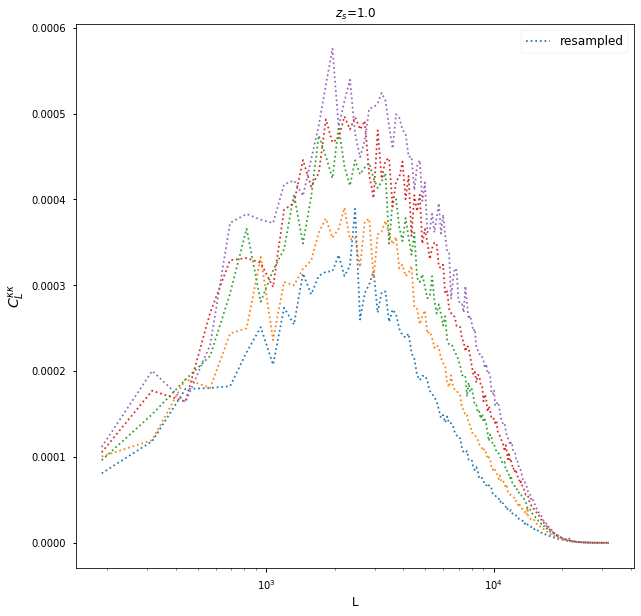

In [16]:
zs=1.
plt.figure(figsize=(10,10))
for jj in range(len(Omega_ms)):
    plt.title('$z_s$=%.1f'%zs,fontsize=12)
    L, clkk, _= get_2Dpower(my_cropped_maps[jj])
    #p= plt.loglog(my_runs[jj].measured_cls[str(zs)]['L'],my_runs[jj].measured_cls[str(zs)]['L']**2*my_runs[jj].measured_cls[str(zs)]['clkk'],label='measured')
    #p = plt.semilogx(my_runs[jj].theory_cls[str(zs)]['L'],my_runs[jj].theory_cls[str(zs)]['L']**2*my_runs[jj].theory_cls[str(zs)]['clkk'])#,color=p[0].get_color(),ls='--',label='halofit')
    plt.semilogx(L,L**2*clkk,ls=':',label='resampled')
    if jj==0:
        plt.legend(fontsize=12)
plt.ylabel('$C_L^{\kappa \kappa}$',fontsize=14)
plt.xlabel('L',fontsize=12)

In [17]:
1305/5

261.0

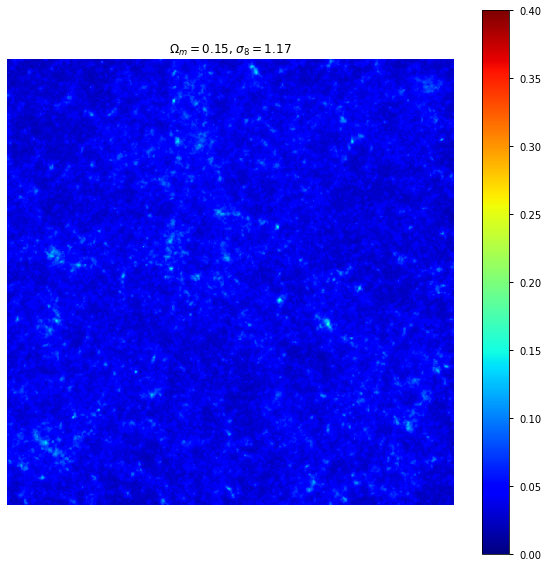

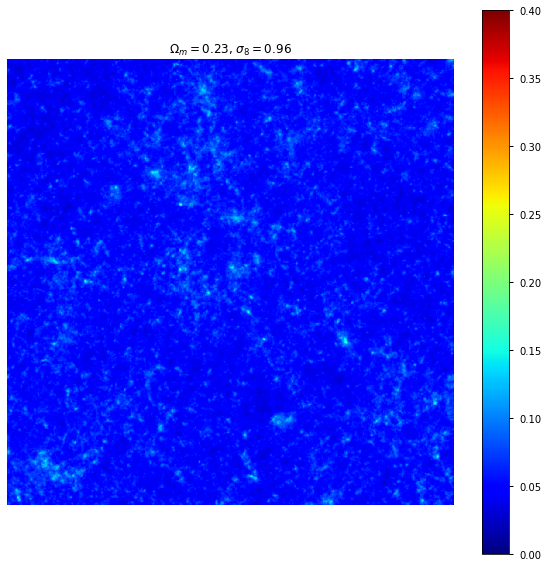

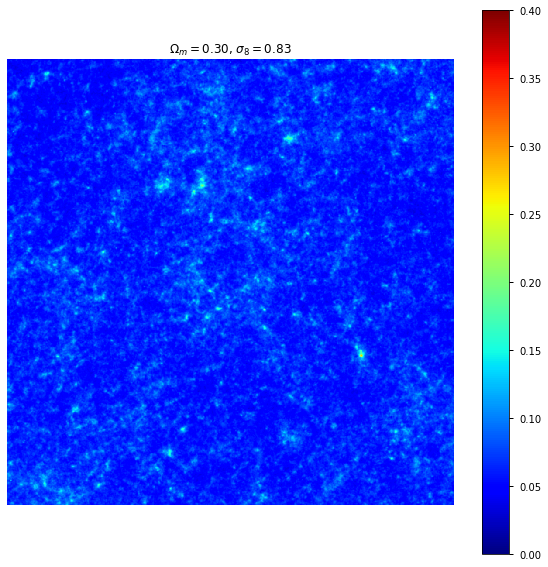

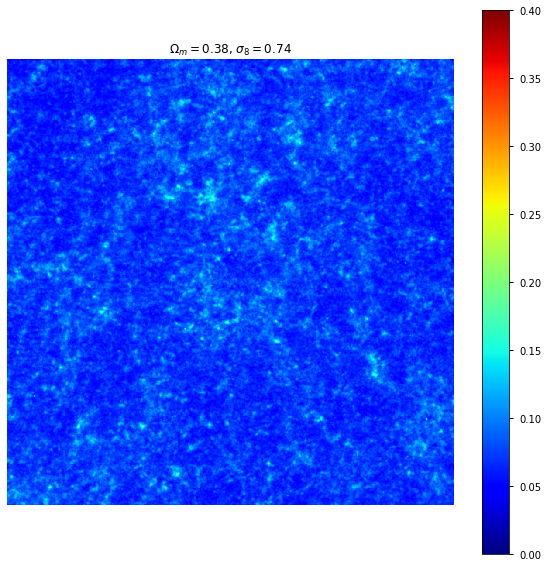

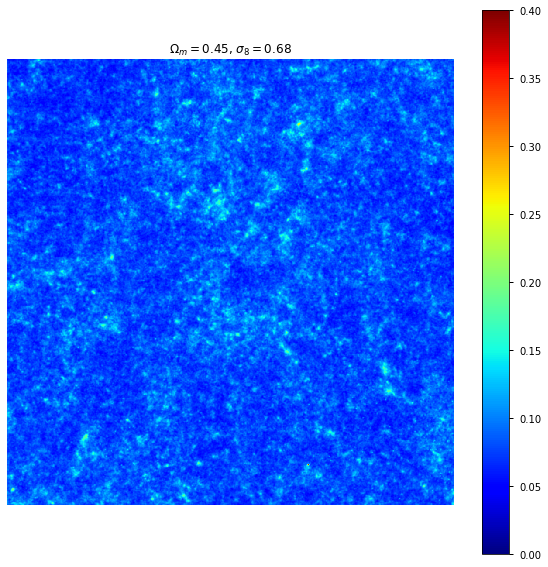

In [20]:
for ii in range(len(Omega_ms)):
    plt.figure(figsize=(10,10))
    plt.title('$\Omega_m=%.2f$, $\sigma_8=%.2f$'%(Omega_ms[ii],sigma8s[ii]))
    plt.imshow(my_cropped_maps[ii],cmap='jet',vmin=0, vmax=0.4)
    plt.colorbar()
    plt.axis('off')
plt.show()